In [3]:
import requests
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import json
from concurrent.futures import ThreadPoolExecutor, as_completed
import logging
from scipy.stats import ttest_ind, f_oneway

In [102]:
# Check if the DataFrame file already exists
path = 'C:/Users/numan/Downloads/Datasets/energy_data.pkl'
df = os.path.exists(path)

if df:
    print(f"Dataset file '{path}' already exists. Skip dataset creation.")

Dataset file 'C:/Users/numan/Downloads/Datasets/energy_data.pkl' already exists. Skip dataset creation.


In [5]:
# link for fetching data using helsinki-openapi.nuuka.cloud API
list_properties_url = "https://helsinki-openapi.nuuka.cloud/api/v1.0/Property/List"
property_search_url = "https://helsinki-openapi.nuuka.cloud/api/v1.0/Property/Search"
hourly_electricity_url = "https://helsinki-openapi.nuuka.cloud/api/v1.0/EnergyData/Hourly/ListByProperty"

In [6]:
# Fetch all property data
response_properties = requests.get(list_properties_url)
properties_data = response_properties.json()
print(properties_data[:5])

[{'locationName': '1000 Hakaniemen kauppahalli', 'propertyName': '1000 Hakaniemen kauppahalli', 'propertyCode': '091-011-9902-0101'}, {'locationName': '1001 Hietalahden kauppahalli', 'propertyName': '1001 Hietalahden kauppahalli', 'propertyCode': '091-004-9902-0008'}, {'locationName': '1002 Vanha kauppahalli', 'propertyName': '1002 Vanha kauppahalli', 'propertyCode': '091-003-9906-0101'}, {'locationName': '1037 Vuotalo', 'propertyName': '1037 Vuotalo', 'propertyCode': '091-054-0179-0003'}, {'locationName': '1507 Suutarilan monitoimitalo/ala-aste ja Lpk Seulanen', 'propertyName': '1507 Suutarilan monitoimitalo/ala-aste ja Lpk Seulanen', 'propertyCode': '091-040-0024-0003'}]


In [7]:
# Extract relevant property information
property_locations = [property_info['locationName'] for property_info in properties_data]
print(property_locations[:5])

['1000 Hakaniemen kauppahalli', '1001 Hietalahden kauppahalli', '1002 Vanha kauppahalli', '1037 Vuotalo', '1507 Suutarilan monitoimitalo/ala-aste ja Lpk Seulanen']


In [18]:
# Function to fetch additional property information
def fetch_additional_property_info(location_name):
    search_params = {
        "SearchString": location_name,
        "SearchFromRecord": "LocationName"
    }
    try:
        response_property_search = requests.get(property_search_url, params=search_params)
        # Raise an error for bad responses
        response_property_search.raise_for_status()  
        property_info = response_property_search.json()
        return property_info
    except requests.RequestException as e:
        print(f"Error fetching property info for {location_name}: {e}")
        return None

In [25]:
def fetch_all_property_info_parallel(property_locations, batch_size=10):
    with ThreadPoolExecutor(max_workers=10) as executor:
        property_info_list = []
        futures = []

        for i in range(0, len(property_locations), batch_size):
            batch_locations = property_locations[i:i + batch_size]

            # Submit tasks for each location in the batch
            batch_futures = [executor.submit(fetch_additional_property_info, loc) for loc in batch_locations]
            futures.extend(batch_futures)

        # Iterate over completed futures and get results as soon as they are available
        for future in as_completed(futures):
            try:
                result = future.result()
                if result:
                    property_info_list.append(result)
            except Exception as e:
                print(f"Error processing future result: {e}")

    return property_info_list

In [26]:
property_info_list = fetch_all_property_info_parallel(property_locations)
property_info_list[0]

Error fetching property info for 2287 Lpk Lasten Kartano/Malmink. NT: 404 Client Error: Not Found for url: https://helsinki-openapi.nuuka.cloud/api/v1.0/Property/Search?SearchString=2287+Lpk+Lasten+Kartano%2FMalmink.+NT&SearchFromRecord=LocationName
Error fetching property info for 6844 Paviljonki- lpk Kukkaniitty ja Blomängen: 404 Client Error: Not Found for url: https://helsinki-openapi.nuuka.cloud/api/v1.0/Property/Search?SearchString=6844+Paviljonki-+lpk+Kukkaniitty+ja+Blom%C3%A4ngen&SearchFromRecord=LocationName
Error fetching property info for 2070 Sophie Mannerheimin koulu/Välskärin: 404 Client Error: Not Found for url: https://helsinki-openapi.nuuka.cloud/api/v1.0/Property/Search?SearchString=2070+Sophie+Mannerheimin+koulu%2FV%C3%A4lsk%C3%A4rin&SearchFromRecord=LocationName


[{'locationName': '1507 Suutarilan monitoimitalo/ala-aste ja Lpk Seulanen',
  'propertyName': '1507 Suutarilan monitoimitalo/ala-aste ja Lpk Seulanen',
  'propertyCode': '091-040-0024-0003',
  'yearOfIntroduction': '1981-01-01T00:00:00',
  'purposeOfUse': 'G monitoimitalo',
  'totalArea': 7354.0,
  'heatedArea': 6150.9,
  'volume': 33650.0,
  'buildingType': 'OtherAssemblyBuilding',
  'latitude': '60.2754845',
  'longitude': '24.9974220',
  'reportingGroups': [{'name': 'Electricity',
    'energyType': 'Electricity',
    'isTopGroup': True},
   {'name': 'Heat', 'energyType': 'Heating', 'isTopGroup': True},
   {'name': 'Water', 'energyType': 'Water', 'isTopGroup': True}],
  'buildings': [{'locationName': '1507 Suutarilan monitoimitalo/ala-aste ja Lpk Seulanen,  21715 monitoimitalo',
    'propertyName': '1507 Suutarilan monitoimitalo/ala-aste ja Lpk Seulanen',
    'propertyCode': '091-040-0024-0003',
    'buildingCode': '1021839448',
    'yearOfIntroduction': '1981-01-01T00:00:00',
    'p

In [80]:
# Create a DataFrame from the additional property information
property_df = pd.DataFrame(property_info_list)
property_df.head()

,0,1
0,{'locationName': '1507 Suutarilan monitoimital...,None
1,{'locationName': '1513 Psykiatrinen poliklinik...,None
2,{'locationName': '1511 Pauligin huvila (disabl...,None
3,{'locationName': '1509 Lpk Karvikka ja rppk Le...,None
4,"{'locationName': '1512 Malmin raitti 3', 'prop...",None


In [81]:
print(property_df.iloc[0, 0])

{'locationName': '1507 Suutarilan monitoimitalo/ala-aste ja Lpk Seulanen', 'propertyName': '1507 Suutarilan monitoimitalo/ala-aste ja Lpk Seulanen', 'propertyCode': '091-040-0024-0003', 'yearOfIntroduction': '1981-01-01T00:00:00', 'purposeOfUse': 'G monitoimitalo', 'totalArea': 7354.0, 'heatedArea': 6150.9, 'volume': 33650.0, 'buildingType': 'OtherAssemblyBuilding', 'latitude': '60.2754845', 'longitude': '24.9974220', 'reportingGroups': [{'name': 'Electricity', 'energyType': 'Electricity', 'isTopGroup': True}, {'name': 'Heat', 'energyType': 'Heating', 'isTopGroup': True}, {'name': 'Water', 'energyType': 'Water', 'isTopGroup': True}], 'buildings': [{'locationName': '1507 Suutarilan monitoimitalo/ala-aste ja Lpk Seulanen,  21715 monitoimitalo', 'propertyName': '1507 Suutarilan monitoimitalo/ala-aste ja Lpk Seulanen', 'propertyCode': '091-040-0024-0003', 'buildingCode': '1021839448', 'yearOfIntroduction': '1981-01-01T00:00:00', 'purposeOfUse': 'G monitoimitalo', 'totalArea': 7354.0, 'heat

In [86]:
# Creating an empty list to store dictionaries
property_info_list = []

# Process row function
def process_row(row):
    try:
        if isinstance(row, str):
            cell_data = json.loads(row)
        elif isinstance(row, dict):
            cell_data = row
        else:
            raise ValueError(f"Unsupported data type: {type(row)}")

        # Using only necessary columns
        extracted_data = {
            'locationName': cell_data.get('locationName'),
            'propertyName': cell_data.get('propertyName'),
            'propertyCode': cell_data.get('propertyCode'),
            'yearOfIntroduction': cell_data.get('yearOfIntroduction'),
            'purposeOfUse': cell_data.get('purposeOfUse'),
            'totalArea': cell_data.get('totalArea'),
            'heatedArea': cell_data.get('heatedArea'),
            'volume': cell_data.get('volume'),
            'buildingType': cell_data.get('buildingType'),
            'latitude': cell_data.get('latitude'),
            'longitude': cell_data.get('longitude')
        }
        property_info_list.append(extracted_data)
    except (json.JSONDecodeError, AttributeError, ValueError):
        pass

# Apply the processing function to each cell in the DataFrame for additional_df
property_df.applymap(process_row)

# Create a DataFrame from the list of dictionaries
property_info_df = pd.DataFrame(property_info_list)
property_info_df.head()

,locationName,propertyName,propertyCode,yearOfIntroduction,purposeOfUse,totalArea,heatedArea,volume,buildingType,latitude,longitude
0,1507 Suutarilan monitoimitalo/ala-aste ja Lpk ...,1507 Suutarilan monitoimitalo/ala-aste ja Lpk ...,091-040-0024-0003,1981-01-01T00:00:00,G monitoimitalo,7354.0,6150.9,33650.0,OtherAssemblyBuilding,60.2754845,24.9974220
1,1513 Psykiatrinen poliklinikka,1513 Psykiatrinen poliklinikka,091-022-0548-0043,1958-01-01T00:00:00,D toimisto,3296.0,2079.0,10793.0,Office,60.1934923,24.9553642
2,1511 Pauligin huvila (disabled),1511 Pauligin huvila,091-014-9903-0102,1899-12-31T00:00:00,G muu kokoontuminen,660.0,529.0,1780.0,OtherAssemblyBuilding,60.1800428,24.9142782
3,1509 Lpk Karvikka ja rppk Lemmikki,1509 Lpk Karvikka ja rppk Lemmikki,091-038-0055-0010,1980-01-01T00:00:00,F lasten päiväkoti,1468.0,1216.5,5354.0,Nursery,60.2449607,25.0077957
4,1512 Malmin raitti 3,1512 Malmin raitti 3,091-038-0107-0016,1929-01-01T00:00:00,G muu kokoontuminen,821.0,542.0,2717.0,Office,60.2528190,25.0081551


In [87]:
property_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 854 entries, 0 to 853
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   locationName        854 non-null    object 
 1   propertyName        846 non-null    object 
 2   propertyCode        842 non-null    object 
 3   yearOfIntroduction  798 non-null    object 
 4   purposeOfUse        844 non-null    object 
 5   totalArea           838 non-null    float64
 6   heatedArea          832 non-null    float64
 7   volume              840 non-null    float64
 8   buildingType        854 non-null    object 
 9   latitude            849 non-null    object 
 10  longitude           849 non-null    object 
dtypes: float64(3), object(8)
memory usage: 73.5+ KB


In [88]:
# Unique values of each column
unique_counts = property_info_df.nunique()

# Display the counts
print(unique_counts)

locationName          758
propertyName          755
propertyCode          643
yearOfIntroduction    118
purposeOfUse           34
totalArea             636
heatedArea            630
volume                602
buildingType           31
latitude              731
longitude             732
dtype: int64


In [32]:
# Function to fetch daily electricity data for a property
def fetch_hourly_data_for_property(property_location):
    hourly_params = {
        "Record": "LocationName",
        "SearchString": property_location,
        "ReportingGroup": "Electricity",
        "StartTime": "2022-01-01",
        "EndTime": "2023-10-31"
    }

    try:
        response_hourly_electricity = requests.get(hourly_electricity_url, params=hourly_params)
        # Raise an error for bad responses
        response_hourly_electricity.raise_for_status()  
        hourly_electricity_data = response_hourly_electricity.json()
        return hourly_electricity_data
    except requests.RequestException as e:
        print(f"Error fetching hourly data for {property_location}: {e}")
        return None

In [33]:
def fetch_hourly_data_for_property_parallel(property_locations, batch_size=10):
    with ThreadPoolExecutor(max_workers=10) as executor:
        hourly_data_list = []
        futures = []

        for i in range(0, len(property_locations), batch_size):
            batch_locations = property_locations[i:i + batch_size]

            # Submit tasks for each location in the batch
            batch_futures = [executor.submit(fetch_hourly_data_for_property, loc) for loc in batch_locations]
            futures.extend(batch_futures)

        # Iterate over completed futures and get results as soon as they are available
        for future in as_completed(futures):
            try:
                result = future.result()
                if result:
                    hourly_data_list.append(result)
            except Exception as e:
                print(f"Error fetching hourly data: {e}")

    return hourly_data_list

In [34]:
hourly_data_list = fetch_hourly_data_for_property_parallel(property_locations)
hourly_data_list[0]

Error fetching hourly data for 1597 Lpk Lauttasaaren Ankkalampi (disabloitu): 404 Client Error: Not Found for url: https://helsinki-openapi.nuuka.cloud/api/v1.0/EnergyData/Hourly/ListByProperty?Record=LocationName&SearchString=1597+Lpk+Lauttasaaren+Ankkalampi+%28disabloitu%29&ReportingGroup=Electricity&StartTime=2022-01-01&EndTime=2023-10-31
Error fetching hourly data for 1652 Laajasalon kirj.NT ja Lpk Koulutanhua,Rppk Nuppula (disabled): 404 Client Error: Not Found for url: https://helsinki-openapi.nuuka.cloud/api/v1.0/EnergyData/Hourly/ListByProperty?Record=LocationName&SearchString=1652+Laajasalon+kirj.NT+ja+Lpk+Koulutanhua%2CRppk+Nuppula+%28disabled%29&ReportingGroup=Electricity&StartTime=2022-01-01&EndTime=2023-10-31
Error fetching hourly data for 1714 Linja-autoasema, Narikka (disabled): 404 Client Error: Not Found for url: https://helsinki-openapi.nuuka.cloud/api/v1.0/EnergyData/Hourly/ListByProperty?Record=LocationName&SearchString=1714+Linja-autoasema%2C+Narikka+%28disabled%29

[{'timestamp': '2022-01-01T00:00:00',
  'reportingGroup': 'Electricity',
  'locationName': '1512 Malmin raitti 3',
  'value': 0.0,
  'unit': 'kWh'},
 {'timestamp': '2022-01-01T01:00:00',
  'reportingGroup': 'Electricity',
  'locationName': '1512 Malmin raitti 3',
  'value': 0.0,
  'unit': 'kWh'},
 {'timestamp': '2022-01-01T02:00:00',
  'reportingGroup': 'Electricity',
  'locationName': '1512 Malmin raitti 3',
  'value': 0.0,
  'unit': 'kWh'},
 {'timestamp': '2022-01-01T03:00:00',
  'reportingGroup': 'Electricity',
  'locationName': '1512 Malmin raitti 3',
  'value': 0.0,
  'unit': 'kWh'},
 {'timestamp': '2022-01-01T04:00:00',
  'reportingGroup': 'Electricity',
  'locationName': '1512 Malmin raitti 3',
  'value': 0.0,
  'unit': 'kWh'},
 {'timestamp': '2022-01-01T05:00:00',
  'reportingGroup': 'Electricity',
  'locationName': '1512 Malmin raitti 3',
  'value': 0.0,
  'unit': 'kWh'},
 {'timestamp': '2022-01-01T06:00:00',
  'reportingGroup': 'Electricity',
  'locationName': '1512 Malmin ra

In [89]:
# Convert the list of dictionaries to a DataFrame
all_properties_hourly_electricity_df = pd.DataFrame(hourly_data_list)

# Display the DataFrame
print("\nDaily Electricity Data for All Properties:")
all_properties_hourly_electricity_df.head()


Daily Electricity Data for All Properties:


,0,1,2,3,4,5,6,7,8,9,...,87518,87519,87520,87521,87522,87523,87524,87525,87526,87527
0,"{'timestamp': '2022-01-01T00:00:00', 'reportin...","{'timestamp': '2022-01-01T01:00:00', 'reportin...","{'timestamp': '2022-01-01T02:00:00', 'reportin...","{'timestamp': '2022-01-01T03:00:00', 'reportin...","{'timestamp': '2022-01-01T04:00:00', 'reportin...","{'timestamp': '2022-01-01T05:00:00', 'reportin...","{'timestamp': '2022-01-01T06:00:00', 'reportin...","{'timestamp': '2022-01-01T07:00:00', 'reportin...","{'timestamp': '2022-01-01T08:00:00', 'reportin...","{'timestamp': '2022-01-01T09:00:00', 'reportin...",...,None,None,None,None,None,None,None,None,None,None
1,"{'timestamp': '2022-01-01T00:00:00', 'reportin...","{'timestamp': '2022-01-01T01:00:00', 'reportin...","{'timestamp': '2022-01-01T02:00:00', 'reportin...","{'timestamp': '2022-01-01T03:00:00', 'reportin...","{'timestamp': '2022-01-01T04:00:00', 'reportin...","{'timestamp': '2022-01-01T05:00:00', 'reportin...","{'timestamp': '2022-01-01T06:00:00', 'reportin...","{'timestamp': '2022-01-01T07:00:00', 'reportin...","{'timestamp': '2022-01-01T08:00:00', 'reportin...","{'timestamp': '2022-01-01T09:00:00', 'reportin...",...,None,None,None,None,None,None,None,None,None,None
2,"{'timestamp': '2022-01-01T00:00:00', 'reportin...","{'timestamp': '2022-01-01T01:00:00', 'reportin...","{'timestamp': '2022-01-01T02:00:00', 'reportin...","{'timestamp': '2022-01-01T03:00:00', 'reportin...","{'timestamp': '2022-01-01T04:00:00', 'reportin...","{'timestamp': '2022-01-01T05:00:00', 'reportin...","{'timestamp': '2022-01-01T06:00:00', 'reportin...","{'timestamp': '2022-01-01T07:00:00', 'reportin...","{'timestamp': '2022-01-01T08:00:00', 'reportin...","{'timestamp': '2022-01-01T09:00:00', 'reportin...",...,None,None,None,None,None,None,None,None,None,None
3,"{'timestamp': '2022-01-01T00:00:00', 'reportin...","{'timestamp': '2022-01-01T01:00:00', 'reportin...","{'timestamp': '2022-01-01T02:00:00', 'reportin...","{'timestamp': '2022-01-01T03:00:00', 'reportin...","{'timestamp': '2022-01-01T04:00:00', 'reportin...","{'timestamp': '2022-01-01T05:00:00', 'reportin...","{'timestamp': '2022-01-01T06:00:00', 'reportin...","{'timestamp': '2022-01-01T07:00:00', 'reportin...","{'timestamp': '2022-01-01T08:00:00', 'reportin...","{'timestamp': '2022-01-01T09:00:00', 'reportin...",...,None,None,None,None,None,None,None,None,None,None
4,"{'timestamp': '2022-01-01T00:00:00', 'reportin...","{'timestamp': '2022-01-01T01:00:00', 'reportin...","{'timestamp': '2022-01-01T02:00:00', 'reportin...","{'timestamp': '2022-01-01T03:00:00', 'reportin...","{'timestamp': '2022-01-01T04:00:00', 'reportin...","{'timestamp': '2022-01-01T05:00:00', 'reportin...","{'timestamp': '2022-01-01T06:00:00', 'reportin...","{'timestamp': '2022-01-01T07:00:00', 'reportin...","{'timestamp': '2022-01-01T08:00:00', 'reportin...","{'timestamp': '2022-01-01T09:00:00', 'reportin...",...,None,None,None,None,None,None,None,None,None,None


In [90]:
print(all_properties_hourly_electricity_df.iloc[0, 0])

{'timestamp': '2022-01-01T00:00:00', 'reportingGroup': 'Electricity', 'locationName': '1512 Malmin raitti 3', 'value': 0.0, 'unit': 'kWh'}


In [91]:
# Creating an empty list to store dictionaries 
data_list = []

# Iterate over DataFrame rows using apply
def process_row(row):
    try:
        if isinstance(row, str):
            cell_data = json.loads(row)
        elif isinstance(row, dict):
            cell_data = row
        else:
            raise ValueError(f"Unsupported data type: {type(row)}")

        extracted_data = {
            'timestamp': cell_data.get('timestamp'),
            'reportingGroup': cell_data.get('reportingGroup'),
            'locationName': cell_data.get('locationName'),
            'consumption': cell_data.get('value'),
            'unit': cell_data.get('unit')
        }
        data_list.append(extracted_data)
    except (json.JSONDecodeError, AttributeError, ValueError):
        pass

# Apply the processing function to each cell in the DataFrame
all_properties_hourly_electricity_df.applymap(process_row)

# Create a DataFrame from the list of dictionaries
hourly_energy_df = pd.DataFrame(data_list)
hourly_energy_df.head()

,timestamp,reportingGroup,locationName,consumption,unit
0,2022-01-01T00:00:00,Electricity,1512 Malmin raitti 3,0.00,kWh
1,2022-01-01T00:00:00,Electricity,1511 Pauligin huvila (disabled),37.13,kWh
2,2022-01-01T00:00:00,Electricity,1000 Hakaniemen kauppahalli,0.04,kWh
3,2022-01-01T00:00:00,Electricity,1508 Monitoimitalo Puustelli,8.92,kWh
4,2022-01-01T00:00:00,Electricity,1509 Lpk Karvikka ja rppk Lemmikki,6.04,kWh


In [92]:
hourly_energy_df.shape

(10447837, 5)

In [93]:
# Unique values of each column
unique_counts = hourly_energy_df.nunique()

# Display the counts
print(unique_counts)

timestamp         101612
reportingGroup         1
locationName         643
consumption       180020
unit                   1
dtype: int64


In [94]:
hourly_energy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10447837 entries, 0 to 10447836
Data columns (total 5 columns):
 #   Column          Dtype  
---  ------          -----  
 0   timestamp       object 
 1   reportingGroup  object 
 2   locationName    object 
 3   consumption     float64
 4   unit            object 
dtypes: float64(1), object(4)
memory usage: 398.6+ MB


In [103]:
# Final df after merging the energy_df with the additional_info_df based on 'locationName'
df = pd.merge(hourly_energy_df, property_info_df, on='locationName', how='left')
df.head()

,timestamp,reportingGroup,locationName,consumption,unit,propertyName,propertyCode,yearOfIntroduction,purposeOfUse,totalArea,heatedArea,volume,buildingType,latitude,longitude
0,2022-01-01T00:00:00,Electricity,1512 Malmin raitti 3,0.00,kWh,1512 Malmin raitti 3,091-038-0107-0016,1929-01-01T00:00:00,G muu kokoontuminen,821.0,542.0,2717.0,Office,60.2528190,25.0081551
1,2022-01-01T00:00:00,Electricity,1511 Pauligin huvila (disabled),37.13,kWh,1511 Pauligin huvila,091-014-9903-0102,1899-12-31T00:00:00,G muu kokoontuminen,660.0,529.0,1780.0,OtherAssemblyBuilding,60.1800428,24.9142782
2,2022-01-01T00:00:00,Electricity,1000 Hakaniemen kauppahalli,0.04,kWh,1000 Hakaniemen kauppahalli,091-011-9902-0101,1912-01-01T00:00:00,C kauppahalli,3669.0,2542.0,18966.0,ShoppingCenterMall,60.1790530,24.9511538
3,2022-01-01T00:00:00,Electricity,1508 Monitoimitalo Puustelli,8.92,kWh,1508 Monitoimitalo Puustelli,"091-033-0232-0003, 091-033-0260-0001",1985-01-01T00:00:00,G monitoimitalo,4060.0,3581.0,19900.0,OtherAssemblyBuilding,60.2461428,24.8599921
4,2022-01-01T00:00:00,Electricity,1509 Lpk Karvikka ja rppk Lemmikki,6.04,kWh,1509 Lpk Karvikka ja rppk Lemmikki,091-038-0055-0010,1980-01-01T00:00:00,F lasten päiväkoti,1468.0,1216.5,5354.0,Nursery,60.2449607,25.0077957


In [104]:
# Unique values of each column
unique_counts = df.nunique()

# Display the counts
print(unique_counts)

timestamp             101612
reportingGroup             1
locationName             643
consumption           180020
unit                       1
propertyName             643
propertyCode             571
yearOfIntroduction       112
purposeOfUse              33
totalArea                575
heatedArea               567
volume                   546
buildingType              31
latitude                 627
longitude                627
dtype: int64


In [105]:
df.shape

(11831561, 15)

In [106]:
# Save the DataFrame to a file for future use
df.to_pickle(path)

In [107]:
# Convert 'timestamp' column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Create new columns for year, day, and hour
df['hour'] = df['timestamp'].dt.hour
df['day'] = df['timestamp'].dt.day_name()
df['year'] = df['timestamp'].dt.year

# Drop the 'timestamp', 'propertyName', 'propertyCode' column
df = df.drop(columns=['reportingGroup', 'timestamp', 'propertyName', 'propertyCode'])

In [20]:
# final_df shape
df.shape

(11831561, 14)

In [108]:
df.head()

,locationName,consumption,unit,yearOfIntroduction,purposeOfUse,totalArea,heatedArea,volume,buildingType,latitude,longitude,hour,day,year
0,1512 Malmin raitti 3,0.00,kWh,1929-01-01T00:00:00,G muu kokoontuminen,821.0,542.0,2717.0,Office,60.2528190,25.0081551,0,Saturday,2022
1,1511 Pauligin huvila (disabled),37.13,kWh,1899-12-31T00:00:00,G muu kokoontuminen,660.0,529.0,1780.0,OtherAssemblyBuilding,60.1800428,24.9142782,0,Saturday,2022
2,1000 Hakaniemen kauppahalli,0.04,kWh,1912-01-01T00:00:00,C kauppahalli,3669.0,2542.0,18966.0,ShoppingCenterMall,60.1790530,24.9511538,0,Saturday,2022
3,1508 Monitoimitalo Puustelli,8.92,kWh,1985-01-01T00:00:00,G monitoimitalo,4060.0,3581.0,19900.0,OtherAssemblyBuilding,60.2461428,24.8599921,0,Saturday,2022
4,1509 Lpk Karvikka ja rppk Lemmikki,6.04,kWh,1980-01-01T00:00:00,F lasten päiväkoti,1468.0,1216.5,5354.0,Nursery,60.2449607,25.0077957,0,Saturday,2022


In [109]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11831561 entries, 0 to 11831560
Data columns (total 14 columns):
 #   Column              Dtype  
---  ------              -----  
 0   locationName        object 
 1   consumption         float64
 2   unit                object 
 3   yearOfIntroduction  object 
 4   purposeOfUse        object 
 5   totalArea           float64
 6   heatedArea          float64
 7   volume              float64
 8   buildingType        object 
 9   latitude            object 
 10  longitude           object 
 11  hour                int32  
 12  day                 object 
 13  year                int32  
dtypes: float64(4), int32(2), object(8)
memory usage: 1.1+ GB


<Axes: >

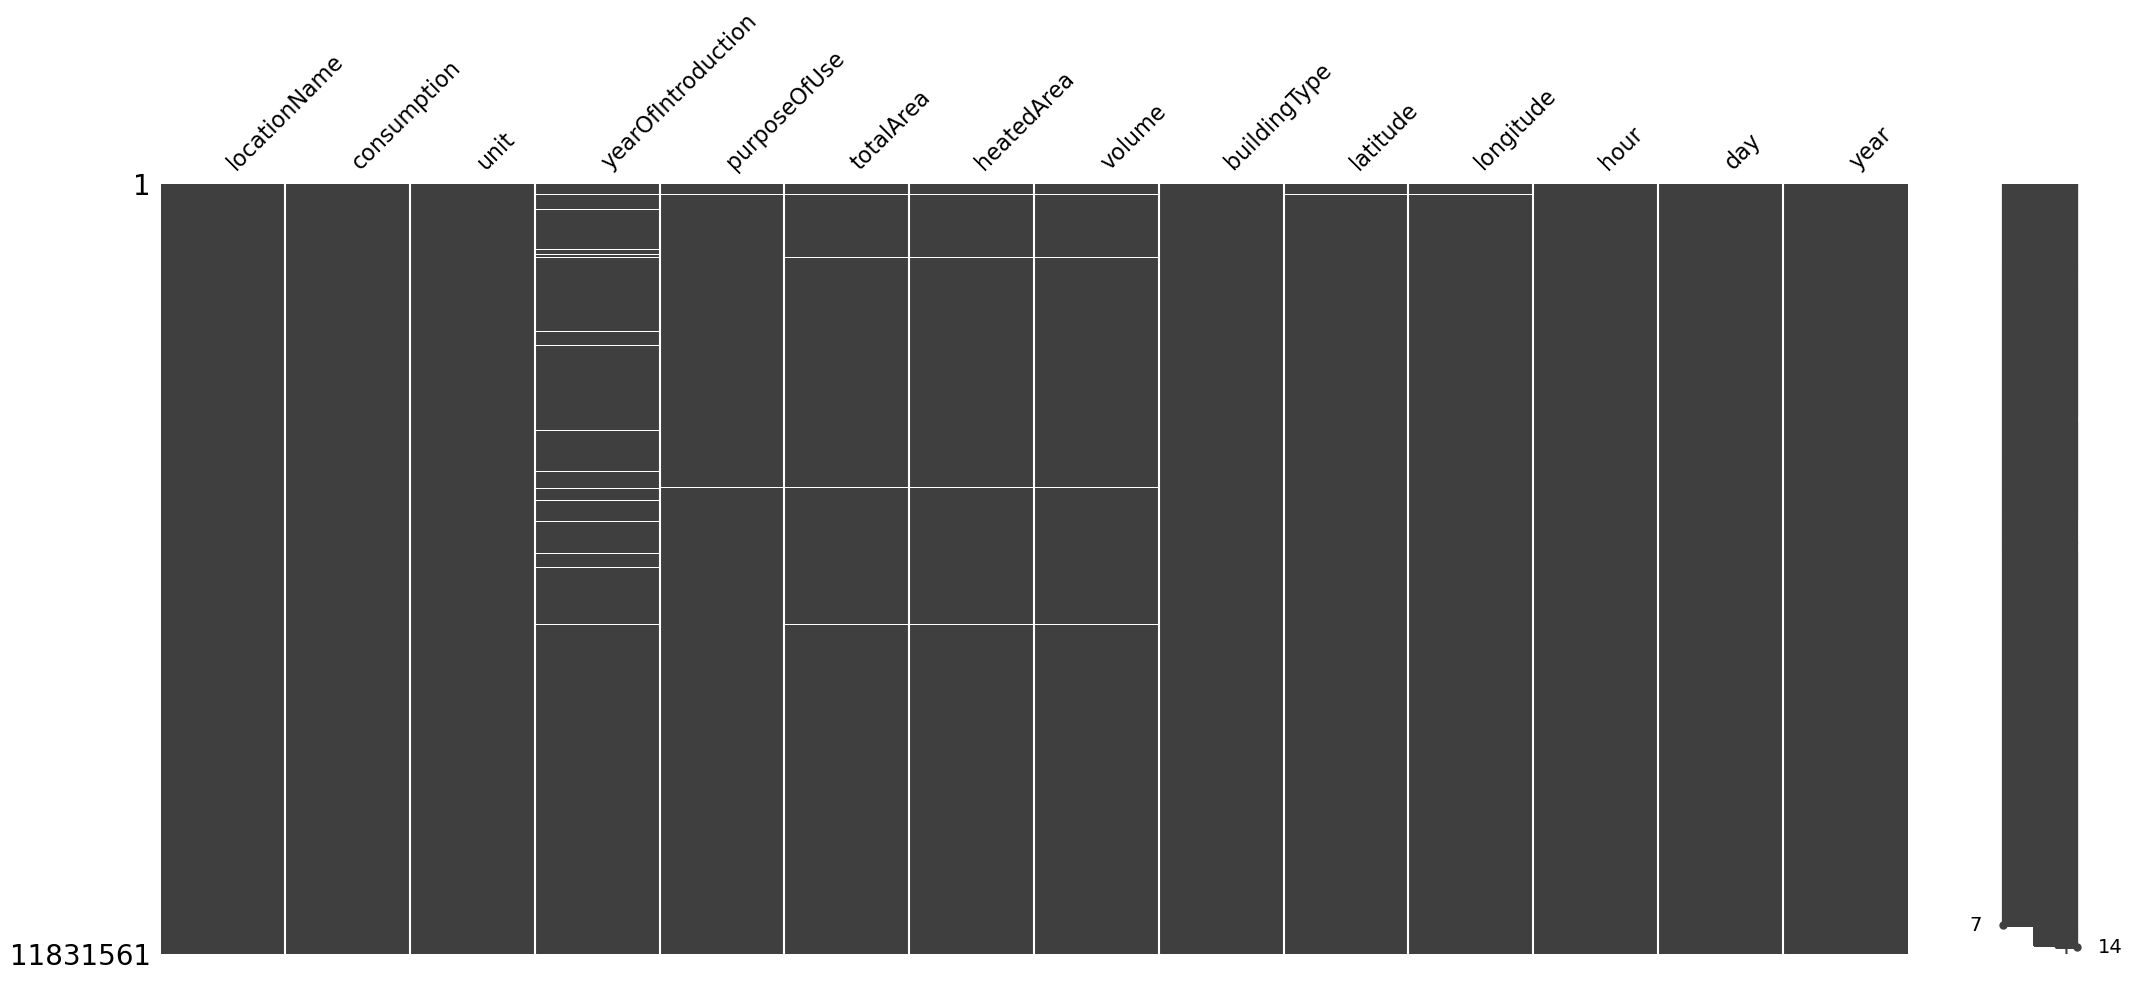

In [110]:
# Visualizing missing values 
msno.matrix(df)

In [111]:
# Print null values of each column
missing_values = pd.concat([df.isnull().sum(), (df.isnull().sum() / len(df) * 100)], axis=1, keys=['Missing Values', '% Missing']).sort_values(by='Missing Values', ascending=False)
print(missing_values)

                    Missing Values  % Missing
yearOfIntroduction          470200   3.974116
heatedArea                   94418   0.798018
totalArea                    46522   0.393203
volume                       42873   0.362361
purposeOfUse                 24279   0.205205
latitude                     15428   0.130397
longitude                    15428   0.130397
locationName                     0   0.000000
consumption                      0   0.000000
unit                             0   0.000000
buildingType                     0   0.000000
hour                             0   0.000000
day                              0   0.000000
year                             0   0.000000


In [112]:
# Description of numeric cols of df
df.describe().T

,count,mean,std,min,25%,50%,75%,max
consumption,11831561.0,114.087461,1397.593107,-1415.84,5.02,13.38,34.66,1086358.625
totalArea,11785039.0,3969.122831,6440.491771,0.00,630.00,1400.00,4942.00,46708.000
heatedArea,11737143.0,3381.536412,5189.047085,0.00,554.00,1175.00,4399.00,41947.600
volume,11788688.0,16574.324512,30594.328282,0.00,1396.00,4970.00,18469.00,209300.000
hour,11831561.0,11.503445,6.922505,0.00,6.00,12.00,18.00,23.000
year,11831561.0,2022.459088,0.498323,2022.00,2022.00,2022.00,2023.00,2023.000


In [113]:
# Unique values of each column
unique_counts = df.nunique()

# Display the counts
print(unique_counts)

locationName             643
consumption           180020
unit                       1
yearOfIntroduction       112
purposeOfUse              33
totalArea                575
heatedArea               567
volume                   546
buildingType              31
latitude                 627
longitude                627
hour                      24
day                        7
year                       2
dtype: int64


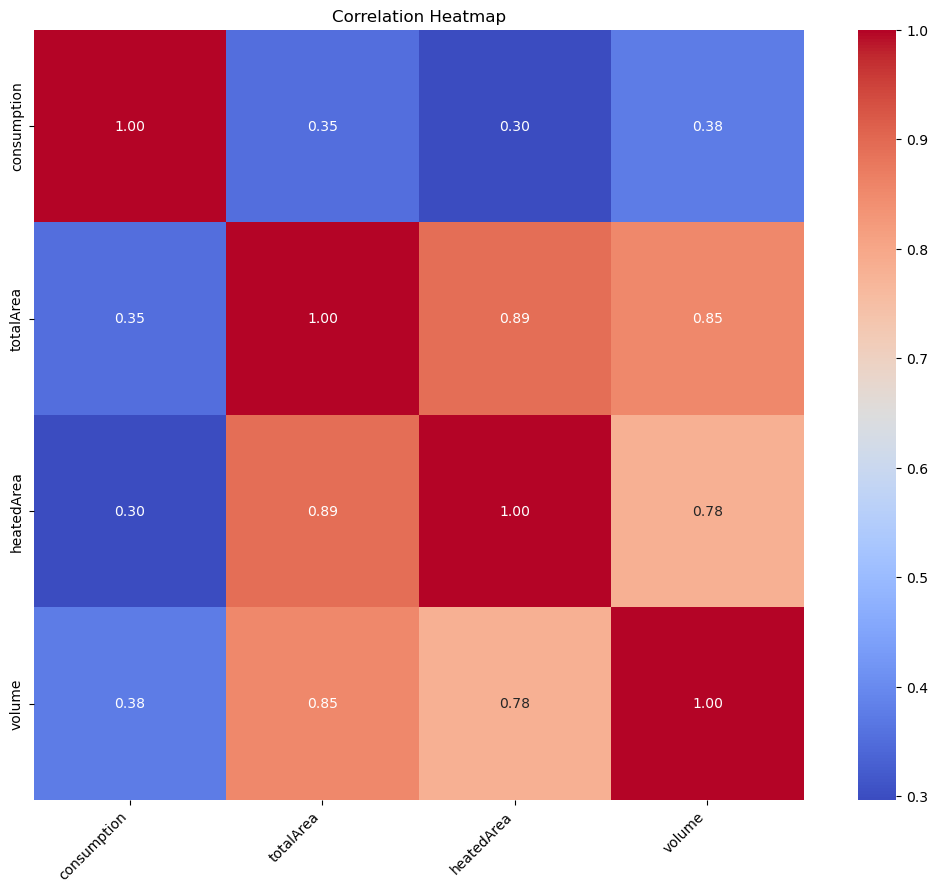

In [114]:
# Select only numeric columns for correlation
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = df[numeric_columns].corr()

# Plot the heatmap
plt.figure(figsize=(14, 10))
heatmap_check = sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap="coolwarm", square=True)
heatmap_check.set_title("Correlation Heatmap")
plt.xticks(rotation=45, ha="right")
plt.show()

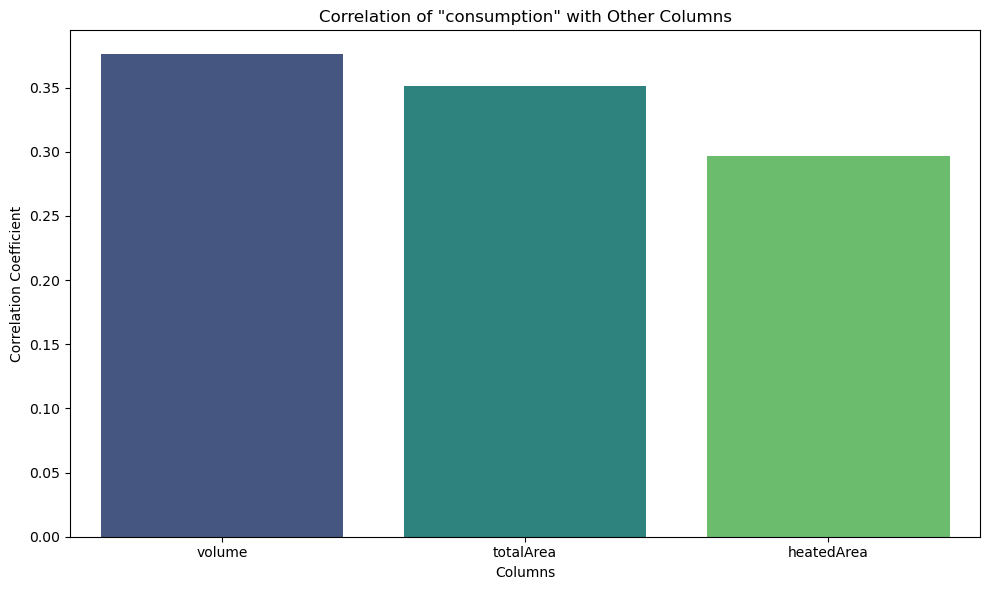

In [115]:
# Setting "consumption" as target
target_column = "consumption"

# Select only numeric columns for correlation
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Calculate the correlations of "consumption" with all other numeric columns
correlations = df[numeric_columns].corr()[target_column].sort_values(ascending=False)

# Exclude the target column from the correlations
correlations = correlations.drop(target_column, errors='ignore')

# Plot the correlations as a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.index, y=correlations.values, palette="viridis")
plt.title(f'Correlation of "{target_column}" with Other Columns')
plt.xlabel("Columns")
plt.ylabel("Correlation Coefficient")
plt.tight_layout()
plt.show()

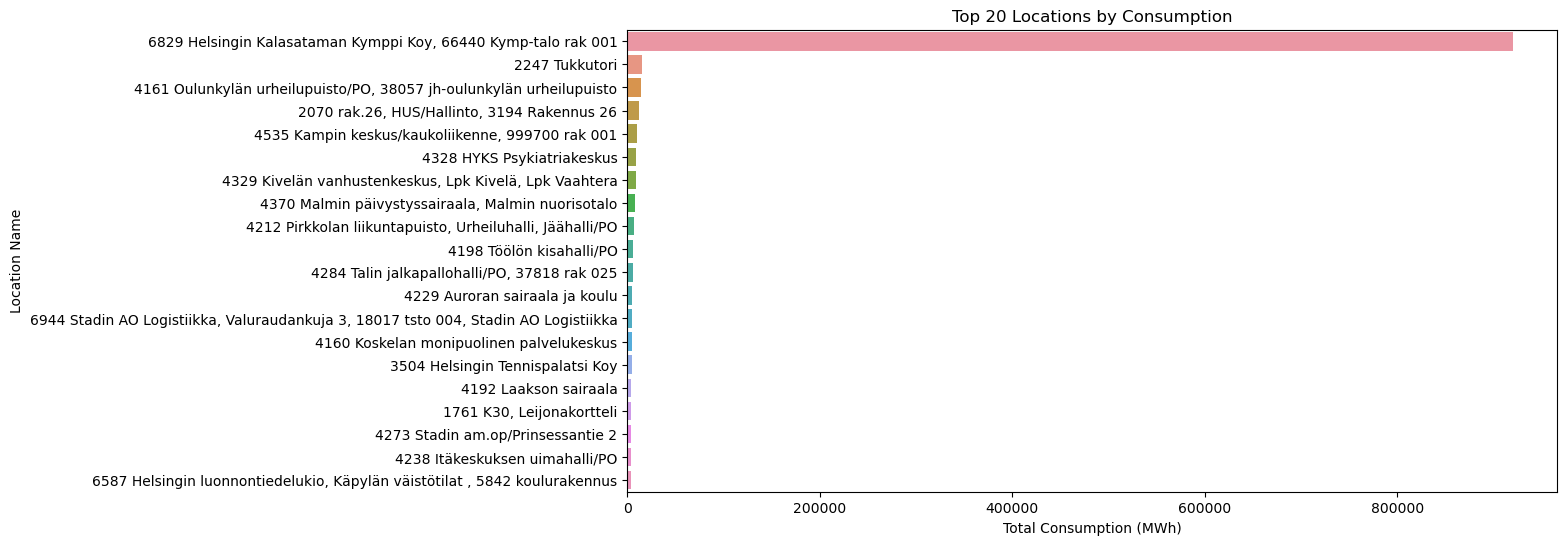

In [116]:
# Top 20 locations by consumption
top_locations = df.groupby('locationName')['consumption'].sum().nlargest(20) / 1000  # Convert from KWh to MWh

plt.figure(figsize=(12, 6))
sns.barplot(x=top_locations.values, y=top_locations.index)
plt.xlabel('Total Consumption (MWh)') 
plt.ylabel('Location Name')
plt.title('Top 20 Locations by Consumption')
plt.show()

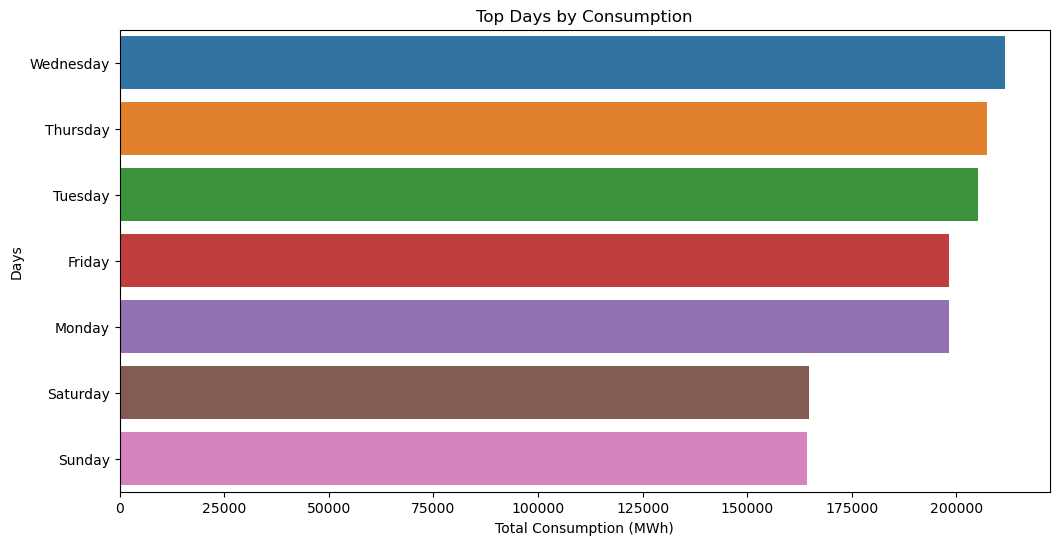

In [117]:
# Top 20 days by consumption
top_days = df.groupby('day')['consumption'].sum().nlargest(20) / 1000 # Convert from KWh to MWh

plt.figure(figsize=(12, 6))
sns.barplot(x=top_days.values, y=top_days.index)
plt.xlabel('Total Consumption (MWh)') 
plt.ylabel('Days')
plt.title('Top Days by Consumption')
plt.show()

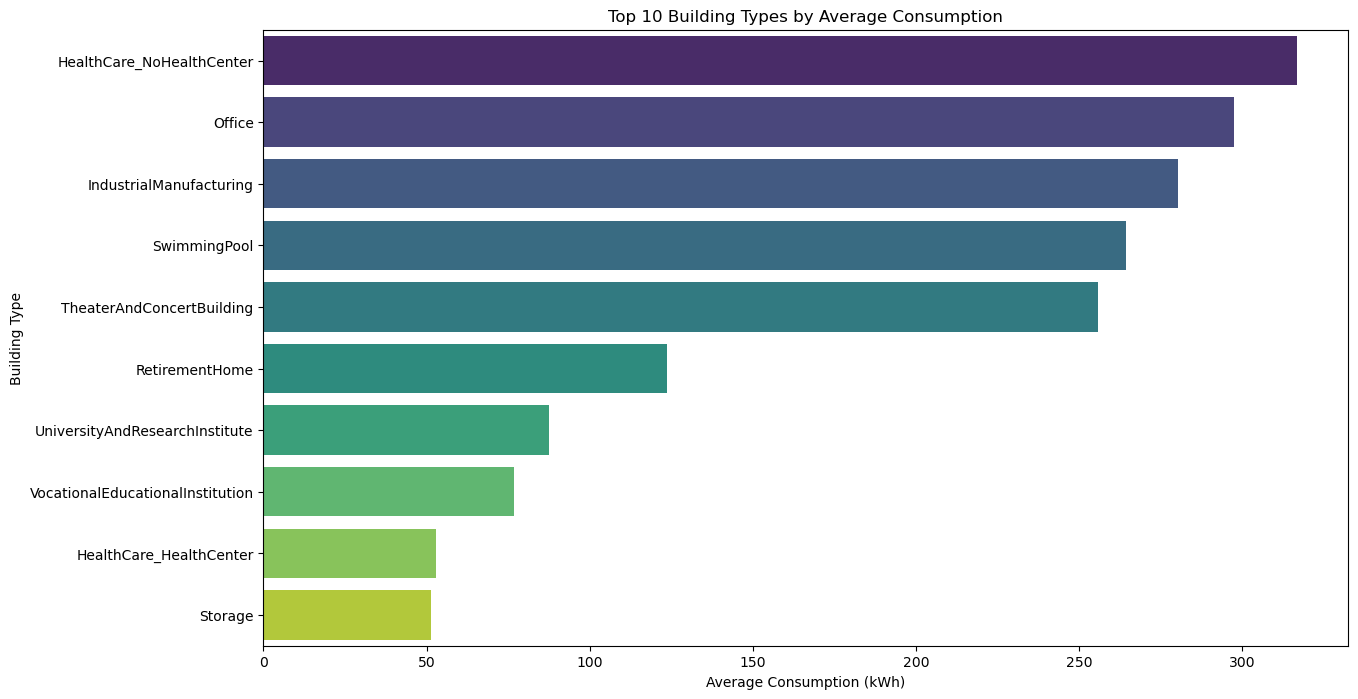

In [118]:
top_n = 10 

# Calculate average consumption for each building type
top_building_types = df.groupby('buildingType')['consumption'].mean().nlargest(top_n)

# Plot the top N building types
plt.figure(figsize=(14, 8))
sns.barplot(x=top_building_types.values, y=top_building_types.index, palette='viridis')
plt.xlabel('Average Consumption (kWh)')
plt.ylabel('Building Type')
plt.title(f'Top {top_n} Building Types by Average Consumption')
plt.show()

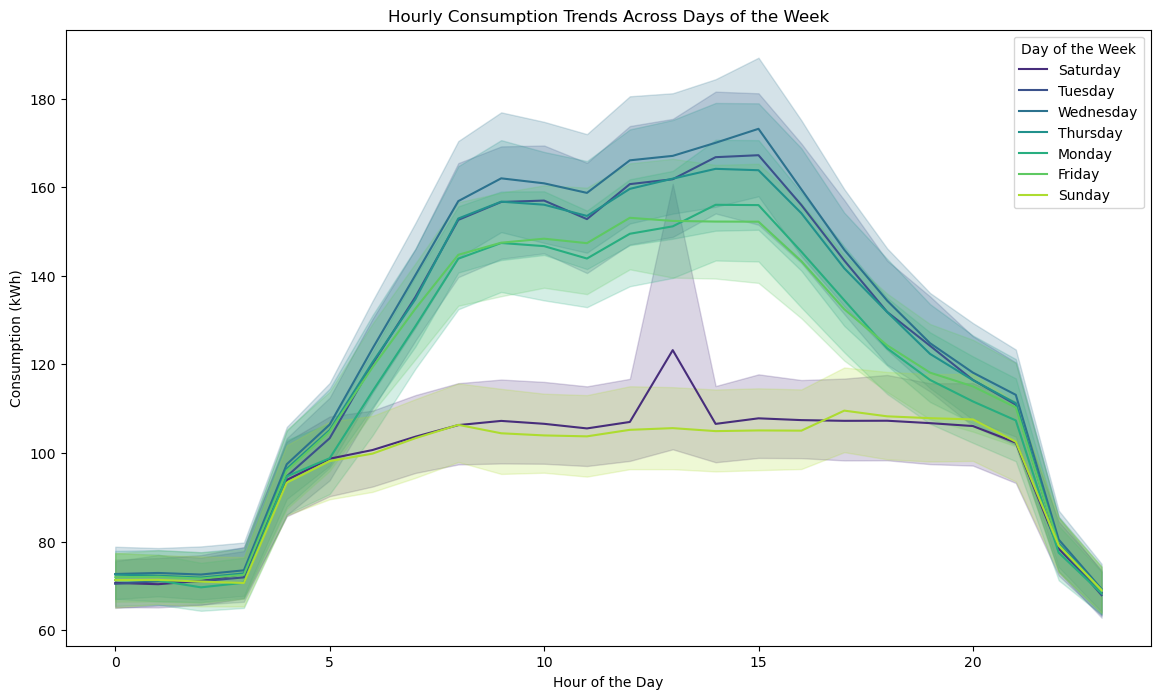

In [119]:
plt.figure(figsize=(14, 8))
sns.lineplot(x='hour', y='consumption', hue='day', data=df, palette='viridis')
plt.xlabel('Hour of the Day')
plt.ylabel('Consumption (kWh)')
plt.title('Hourly Consumption Trends Across Days of the Week')
plt.legend(title='Day of the Week', bbox_to_anchor=(1, 1))
plt.show()

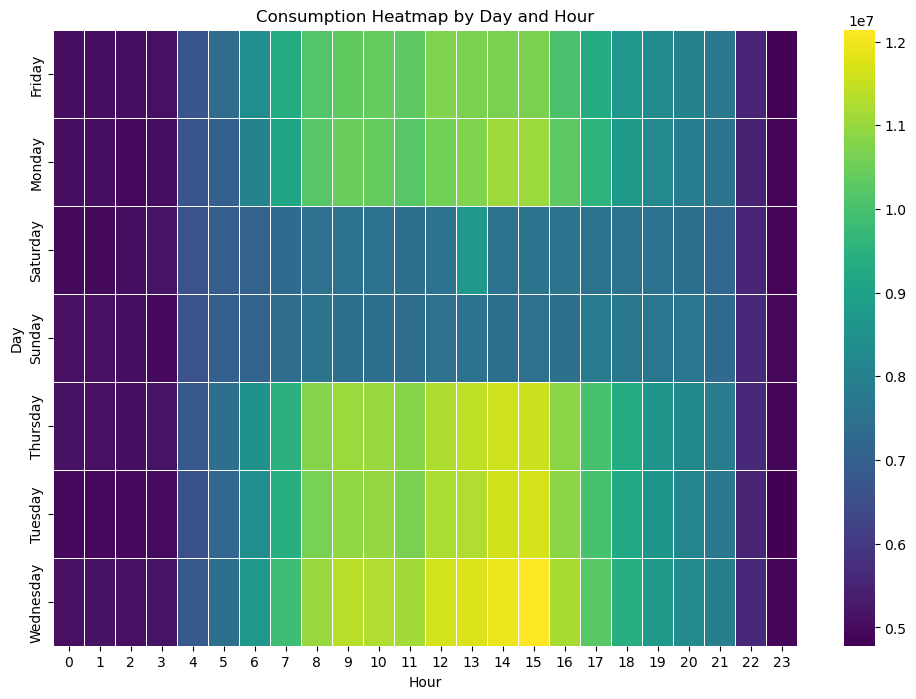

In [120]:
pivot_df = df.pivot_table(index='day', columns='hour', values='consumption', aggfunc='sum')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_df, cmap='viridis', linewidths=.5)
plt.xlabel('Hour')
plt.ylabel('Day')
plt.title('Consumption Heatmap by Day and Hour')
plt.show()

In [121]:
# H0: There is no significant difference in consumption between weekdays and weekends.
# H1: There is a significant difference in consumption between weekdays and weekends.

# Create a new column to categorize weekdays and weekends
df['weekday_category'] = np.where(df['day'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']), 'weekday', 'weekend')

# Extract consumption data for weekdays and weekends
consumption_weekday = df.loc[df['weekday_category'] == 'weekday', 'consumption']
consumption_weekend = df.loc[df['weekday_category'] == 'weekend', 'consumption']

# Perform independent two-sample t-test
t_stat, p_value = ttest_ind(consumption_weekday, consumption_weekend, equal_var=False)

print(f'T-Statistic: {t_stat}\nP-value: {p_value}')

# Set the significance level (alpha)
alpha = 0.05

# Compare p-value with alpha to make a decision
if p_value < alpha:
    print("Reject the null hypothesis.")
    print("There is a significant difference in consumption between weekdays and weekends.")
else:
    print("Fail to reject the null hypothesis.")
    print("There is no significant difference in consumption between weekdays and weekends.")

T-Statistic: 28.413694952126438
P-value: 1.4022199518532886e-177
Reject the null hypothesis.
There is a significant difference in consumption between weekdays and weekends.


In [122]:
# H0: There is no significant difference in consumption among different building types.
# H1: There is a significant difference in consumption among different building types.

# Extract consumption data for each building type
building_types = df['buildingType'].unique()

# Create a dictionary to store consumption data for each building type
consumption_data_by_building = {building: df.loc[df['buildingType'] == building, 'consumption'] for building in building_types}

# Perform one-way ANOVA
f_stat, p_value = f_oneway(*consumption_data_by_building.values())

print(f'F-Statistic: {f_stat}\nP-value: {p_value}')

# Set the significance level (alpha)
alpha = 0.05

# Compare p-value with alpha to make a decision
if p_value < alpha:
    print("Reject the null hypothesis.")
    print("There is a significant difference in consumption among different building types.")
else:
    print("Fail to reject the null hypothesis.")
    print("There is no significant difference in consumption among different building types.")

F-Statistic: 3281.6747161530234
P-value: 0.0
Reject the null hypothesis.
There is a significant difference in consumption among different building types.
